# Kv 2.1 parameter extraction

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import stfio
from analysis_helpers import *

/usr/lib64/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
write = False
paint = False
filebase = '/home/kernfel/Documents/Data/Oocytes/2018_05_03_%04d.atf'
fileno, fileno2, fileno3, targetno = 19,20,21,22
factor = 1
savebase = filebase[:-4] % fileno + '-' + str(fileno3 or fileno2)
paramsfile = filebase[:-4] % targetno + '.params'
params = dict()
tres = 0.025 # Time of one sample in ms

In [3]:
rec = read_2channel_ATF(filebase % fileno, current_factor = factor)
rec2 = read_2channel_ATF(filebase % (fileno2), current_factor = factor)
rec3 = read_2channel_ATF(filebase % (fileno3)) if fileno3 else None

## Sanity checks

To make sure we've got the right recordings, let's visualise the full trace stacks:

In [4]:
t = np.arange(len(rec.voltage[0])) * tres
t2 = np.arange(len(rec2.voltage[0])) * tres
t3 = np.arange(len(rec3.voltage[0])) * tres if rec3 else None

def rawplot(ax, T, Y, ylabel=''):
    for y in Y:
        plt.plot(T, y)
    plt.xlabel('Time [ms]')
    plt.ylabel(ylabel)

if paint:
    fig = plt.figure(figsize=(15,10))
    fig.suptitle('Voltage clamp families')

    rawplot(plt.subplot(2,3,1), t, rec.voltage, 'Voltage [mV]')
    rawplot(plt.subplot(2,3,2), t2, rec2.voltage)
    if rec3: rawplot(plt.subplot(2,3,3), t3, rec3.voltage)

    rawplot(plt.subplot(2,3,4), t, rec.current, u'Current [μA]')
    rawplot(plt.subplot(2,3,5), t2, rec2.current)
    if rec3: rawplot(plt.subplot(2,3,6), t3, rec3.current)

    if write:
        fig.savefig(savebase + '.family.png')

Let's sanity check the step boundaries. The vertical lines should mark the exact beginning of the step and at least the end of the capacitive spike. Should the latter not coincide, the limits needs to be adjusted!

In [5]:
# The start and end of the step, with some room for the capacitive current to dissipate:
rec_limits = (5200, 44800)

# The true step time
rec_step_t0 = 4937

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec.current:
        plt.plot(I[4000:6000])

    plt.subplot(2,3,2)
    for I in rec.current:
        plt.plot(I[4927:4950])
    plt.axvline(rec_step_t0 - 4927)

    plt.subplot(2,3,3)
    for I in rec.current:
        plt.plot(I[rec_step_t0:rec_step_t0 + 5*(rec_limits[0]-rec_step_t0)])
    plt.axvline(rec_limits[0] - rec_step_t0)

    plt.subplot(2,1,2)
    for I in rec.current:
        plt.plot(I[rec_limits[0]:rec_limits[1]])

In [6]:
# The start and end of the step -- here, the first number is the true step time
rec2_limits = (4750, 40000)

# The cutoff for the tail current as used in the tail fitting procedure; this should mark the end of the capacitive spike
rec2_cut, dummy = get_tail_cut(rec2, rec2_limits[0])

if paint:
    plt.figure(figsize=(16,8))

    plt.subplot(2,3,1)
    for I in rec2.current:
        plt.plot(I[4000:6000])

    plt.subplot(2,3,2)
    for I in rec2.current:
        plt.plot(I[4740:4780])
    plt.axvline(rec2_limits[0] - 4740)

    plt.subplot(2,3,3)
    for I in rec2.current:
        plt.plot(I[rec2_limits[0]:rec2_limits[0] + 4*(rec2_cut-rec2_limits[0])])
    plt.axvline(rec2_cut-rec2_limits[0])
    plt.ylim(-2,4)

    plt.subplot(2,1,2)
    for I in rec2.current:
        plt.plot(I[rec2_cut:rec2_limits[1]])

Finally, a sanity check for the third (capacitance) recording, showing a step down and the subsequent step up:

In [7]:
# Index of the first step
rec3_offset = 322

# Step spec
rec3_stepdur = 2000
rec3_nsteps = 9

if rec3 and paint:
    plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    for V in rec3.voltage:
        plt.plot(t3[300:350], V[300:350])
        plt.plot(t3[300:350], V[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,2)
    for I in rec3.current:
        plt.plot(t3[300:350], I[300:350])
        plt.plot(t3[300:350], I[300+rec3_stepdur:350+rec3_stepdur])
    plt.axvline(t3[rec3_offset])

    plt.subplot(1,3,3)
    for V in rec3.voltage:
        plt.plot(V[rec3_offset:rec3_offset+rec3_stepdur])
        plt.plot(V[rec3_offset + (rec3_nsteps-1)*rec3_stepdur:rec3_offset + rec3_nsteps*rec3_stepdur])

## Measurements

### Leak current

In [8]:
if paint:
    fig, ax = plt.subplots()
else:
    ax = None
    
fit_leak(rec, params, ax, rec_limits)

if paint:
    plt.title('Leak conductance fit and activation I-V')
    if write:
        plt.savefig(savebase + '.leak_IV.png')

### Potassium current

In [9]:
fit_tails_exp2(rec2, rec2_limits[0], rec2_limits[1])

if paint:
    fig = plt.figure(figsize=(15, 5))

    plt.subplot(1,2,1)
    plot_tail_fit_exp2(rec2, params, rec2.tail_cut, 10000, tres, range(0, len(rec2.tails), 2))

    plt.subplot(1,2,2)
    plot_tail_fit_exp2(rec2, params, rec2_limits[0] - 20, 6000, tres, range(0, len(rec2.tails), 1))

    fig.suptitle('Tail current fits')
    if write:
        fig.savefig(savebase + '.tail_fits.png')

analysis_helpers.py:100: RuntimeWarning: overflow encountered in exp
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])
analysis_helpers.py:100: RuntimeWarning: overflow encountered in multiply
  return p[0]*np.exp(-t/p[1]) + p[2]*np.exp(-t/p[3])


In [10]:
tail_t0 = [exp2_decay(0, rec2.pdecay[i]) for i in range(len(rec2.tails))]

included = linear_exclude_outliers(rec2.tail_voltages, tail_t0)
tail_I = np.array(tail_t0)[included]
tail_V = np.array(rec2.tail_voltages)[included]

# Fit to the positive current values only
for i in range(len(tail_I)-1, 0, -1):
    if tail_I[i] < 0:
        tail_fit_from = i+1
        break

fit_IV(tail_I[tail_fit_from:], tail_V[tail_fit_from:], params, 'K')

if paint:
    fig, ax = plt.subplots()
    IVplot(tail_I, tail_V, ax)

    tail_plot_V = np.array([-90, -30])
    ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

    ax.set_title('Potassium fit and tail current I-V')
    if write:
        plt.savefig(savebase + '.tail_IV.png')

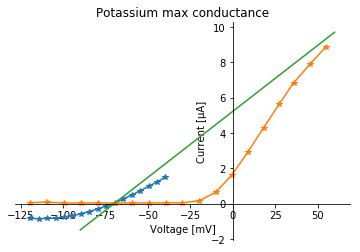

In [11]:
fig, ax = plt.subplots()
IVplot(tail_I, tail_V, ax)

median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
peak_currents = [np.max(I[rec_limits[0]:rec_limits[1]]) - params['I_leak'](V)
                 for I,V in zip(rec.current, median_voltages)]
IVplot(peak_currents, median_voltages, ax)

params['g_K'] = 1.05*peak_currents[-1] / (median_voltages[-1] - params['E_K'])

tail_plot_V = np.array([-90,60])
ax.plot(tail_plot_V, params['I_K'](tail_plot_V))

ax.set_title('Potassium max conductance')
if paint and write:
    plt.savefig(savebase + '.gK.png')

### Capacitance

In [12]:
if rec3:
    params['C'] = fit_capacitance(rec3, tres, rec3_offset, rec3_stepdur, rec3_nsteps)
else:
    params['C'] = fit_capacitance_rec(rec, tres, rec_step_t0, rec3_stepdur)

In [13]:
# RTDO accounts in mV, nA, μS and is not unit-aware
params_rtdo = params.copy()
params_rtdo['g_leak'] *= 1e3
params_rtdo['g_K'] *= 1e3

pstr = '\
gl:\t%(g_leak)f μS\n\
El:\t%(E_leak)f mV\n\
gK:\t%(g_K)f μS\n\
EK:\t%(E_K)f mV\n\
C:\t%(C)f nF' % params_rtdo

print pstr

if write:
    f = open(paramsfile, 'w')
    f.write(pstr)
    f.close()

gl:	2.035259 μS
El:	-18.953572 mV
gK:	74.683587 μS
EK:	-69.977615 mV
C:	90.721847 nF


### Tail fit check: Trying to clean the traces first
I thought removing the capacitance spike might help in figuring out what's going on with the tail fits, but the 10mV jump artifact clearly isn't representative of the spike at 100+ mV...

In [14]:
tailtest = False
if tailtest:
    plt.figure(figsize=(16,8))
    width = 200

    noleak_tails = [I - np.median(I[-8000:]) for I in [c[rec2_limits[0]:rec2_limits[1]] for c in rec2.current]]

    plt.subplot(4,1,1)
    for I in noleak_tails:
        plt.plot(I[:width])

    cap_currents_leaky = [np.array(rec3.current[0][i:i+rec3_stepdur])
                          for i in np.arange(rec3_nsteps)*rec3_stepdur + rec3_offset]
    cap_currents = [I - np.median(I[rec3_stepdur*3/4]) for I in cap_currents_leaky]
    cap_voltages = np.diff([np.median(rec3.voltage[0][:rec3_offset])] + \
                           [np.median(rec3.voltage[0][i:i+rec3_stepdur]) 
                            for i in np.arange(rec3_nsteps)*rec3_stepdur + rec3_offset])
    cap_normcurrent = np.median([I/V for I,V in zip(cap_currents, cap_voltages)], axis=0)
    plt.subplot(4,1,2)
    plt.plot(cap_normcurrent[:width])

    tail_Vstep = [np.median(V[rec2_limits[0]:rec2_limits[1]]) - np.median([VV for VV in V[:rec2_limits[0]] if VV>0])
                  for V in rec2.voltage]
    tail_Ipre = [np.median(I[rec2_limits[0]-50:rec2_limits[0]]) for I in rec2.current]
    clean_tails = np.copy(noleak_tails)
    for I,V,Ipre in zip(clean_tails, tail_Vstep, tail_Ipre):
        I[:rec3_stepdur] -= np.clip(cap_normcurrent*V, -20-Ipre,20-Ipre)

    plt.subplot(2,1,2)
    tx = np.arange(width)*tres
    for I in clean_tails:
        plt.plot(tx, I[:width])

    normcur_peak = np.argmax(cap_normcurrent)
    cutoff = normcur_peak + np.sum(cap_normcurrent[normcur_peak:] > 0.05*cap_normcurrent[normcur_peak])
    plt.axvline(cutoff*tres)

    cut_tails = [I[cutoff:] - np.median(I[-8000:]) for I in clean_tails]
    p = fit_exp2(cut_tails, np.arange(len(cut_tails[0])) + cutoff, min_tau = 10)

    plt.gca().set_prop_cycle(None)
    for pp in p:
        plt.plot(tx, exp2_decay(np.arange(width), pp), linewidth=1)

In [15]:
if tailtest:
    tail_t0_alternative = [exp2_decay(0, pp) for pp in p]
    tail_t0 = [exp2_decay(0, rec2.pdecay[i]) for i in range(len(rec2.tails))]

    fig, ax = plt.subplots()
    IVplot(tail_t0, rec2.tail_voltages, ax)
    IVplot(tail_t0_alternative, rec2.tail_voltages, ax)

### Finding the activation peak times for mixed recordings

t_peak [samples] = -386.960332 * V + 26923.448908


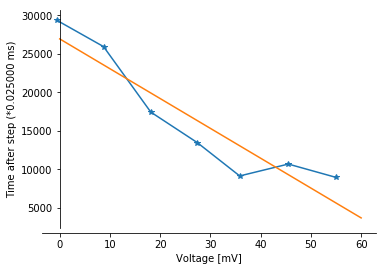

In [16]:
findpeaktimes = False
if findpeaktimes:
    median_voltages = [np.median(V[rec_limits[0]:rec_limits[1]]) for V in rec.voltage]
    peak_currents = [np.max(I[rec_limits[0]:rec_limits[1]]) - params['I_leak'](V)
                     for I,V in zip(rec.current, median_voltages)]
    peak_current_t = [np.argmax(I[rec_limits[0]:rec_limits[1]]) + rec_limits[0]-rec_step_t0 for I in rec.current]
    
    # Use reliable peaks only
    gmax = max(peak_currents)
    for i in range(len(peak_currents)-1, 0, -1):
        if peak_currents[i] < 0.1 * gmax:
            time_fit_from = i+1
            break
    
    fig, ax = plt.subplots()
    IVplot(peak_current_t[time_fit_from:], median_voltages[time_fit_from:], ax,
           Ilabel = 'Time after step (*%f ms)' % tres)
    
    # Since this APPROXIMATELY linear:
    p = np.polyfit(median_voltages[time_fit_from:], peak_current_t[time_fit_from:], 1)
    Vplot = np.array([0,60])
    peaktime = lambda V: p[0]*V + p[1]
    plt.plot(Vplot, peaktime(Vplot))
    
    print 't_peak [samples] = %f * V + %f' % (p[0], p[1])

Solving the inverse problem like...

fraction of remaining current = 0.001807 * V + 0.039792


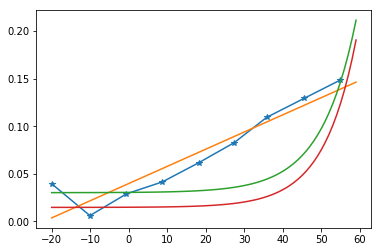

In [18]:
peaktest = False
if peaktest:
    # From Kv14, 2017_12_06_36-37, good enough for a rough approximation:
    peaktimes = lambda V: 124.565668 * np.exp(-0.030378 * V) + 254.206984
    remaining_fraction = [(I[rec_step_t0+int(peaktimes(V))] - params['I_leak'](V)) / peak
                          for peak,I,V in zip(peak_currents, rec.current, median_voltages)
                          if V > -20]
    med_volt = median_voltages[-len(remaining_fraction):]
    plt.plot(med_volt, remaining_fraction, '-*')
    
    p = np.polyfit(med_volt, remaining_fraction, 1)
    
    Vplot = np.arange(-20,60)
    plt.plot(Vplot, Vplot*p[0] + p[1])
    
    # From the forward problem, the fraction of Kv1.4 current at Kv2.1 peaks:
    plt.plot(Vplot, 0.000164 * np.exp(0.118269 * Vplot) + 0.014723)
    
    print 'fraction of remaining current = %f * V + %f' % (p[0], p[1])

Comment on the above: Apart from possibly the highest step, estimating the Kv1.4 current first, at their peaks, is preferable and likely to yield a better estimate.

On the other hand, I could attempt to use these rough fractional estimates to *calculate* the unpolluted maxima like so:

$$peak_1 = I_1 + f_2 I_2$$
$$peak_2 = I_2 + f_1 I_1$$

$$I_1 = peak_1 - f_2 I_2$$
$$I_2 = peak_2 - f_1 I_1 = peak_2 - f_1 peak_1 + f_1 f_2 I_2$$

$$I_2 = \frac{(peak_2 - f_1 peak_1)}{(1 - f_1 f_2)}$$
and equivalently for $I_1$, where $peak_i$ are the observed current peaks, $f_i$ are the fractions of current $i$ remaining at the other peak, and $I_i$ are the estimated current maxima at their respective peaks.